In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import mean_squared_error, r2_score
import cvxpy as cp

In [4]:
df_final = pd.read_csv("../data/df_final.csv")
df_final['v2x_polyarchy_diff'] = abs(df_final['v2x_polyarchy_o'] - df_final['v2x_polyarchy_d'])
df_final['v2x_libdem_diff'] = abs(df_final['v2x_libdem_o'] - df_final['v2x_libdem_d'])
df_final['v2x_partipdem_diff'] = abs(df_final['v2x_partipdem_o'] - df_final['v2x_partipdem_d'])
df_final['v2x_delibdem_diff'] = abs(df_final['v2x_delibdem_o'] - df_final['v2x_delibdem_d'])
df_final['v2x_egaldem_diff'] = abs(df_final['v2x_egaldem_o'] - df_final['v2x_egaldem_d'])
df_final.drop(columns=[
    'v2x_polyarchy_o', 'v2x_polyarchy_d',
    'v2x_libdem_o', 'v2x_libdem_d',
    'v2x_partipdem_o', 'v2x_partipdem_d',
    'v2x_delibdem_o', 'v2x_delibdem_d',
    'v2x_egaldem_o', 'v2x_egaldem_d'
], inplace=True)

In [5]:
df_final.columns

Index(['year', 'country_id_o', 'country_o', 'country_id_d', 'country_d',
       'contig', 'distcap', 'dist', 'comlang_off', 'comlang_ethno', 'comrelig',
       'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'fta_wto',
       'tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_imf_o',
       'tradeflow_imf_d', 'IdealPointDistance', 'arms', 'tot_o', 'tot_d',
       'tgdp_ratio_o', 'tgdp_ratio_d', 'avgtradeflow', 'logtradeflow',
       'allexports', 'chemicalexports', 'consumerexports', 'foodexports',
       'machineryexports', 'manufacturesexports', 'logallexports',
       'logchemicalexports', 'logconsumerexports', 'logfoodexports',
       'logmachineryexports', 'logmanufacturesexports', 'v2x_polyarchy_diff',
       'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff',
       'v2x_egaldem_diff'],
      dtype='object')

In [6]:
df_final.dropna(subset=['logallexports'], inplace=True)

In [9]:
geo_vars = ['comlang_off', 'comlang_ethno', 'comrelig', 'fta_wto', 'IdealPointDistance', 'arms', 
              'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff', 'v2x_egaldem_diff']
scaler_geo = StandardScaler()
df_final[geo_vars] = scaler_components.fit_transform(df_final[components])

In [13]:
fa = FactorAnalysis(n_components=1, random_state=42)
factor_scores = fa.fit_transform(df_final[geo_vars])

df_final['geopolitical_composite'] = factor_scores[:, 0]

In [18]:
corr = np.corrcoef(df_final['geopolitical_composite'], df_final['logallexports'])[0, 1]
print("Initial correlation between composite and logallexports:", corr)

Initial correlation between composite and logallexports: -0.3686728275590426


In [17]:
# flip the sign of the composite so that higher values represent more (negative) geopolitical distance.
if corr > 0:
    df_final['geopolitical_composite'] *= -1

In [19]:
scaler_comp = StandardScaler()
df_final['geopolitical_composite'] = scaler_comp.fit_transform(df_final[['geopolitical_composite']])

In [20]:
other_features = ['distcap', 'gdpcap_d', 'pop_d']
scaler_others = StandardScaler()
df_final[other_features] = scaler_others.fit_transform(df_final[other_features])

In [22]:
X = np.hstack([np.ones((df_final.shape[0], 1)),
               df_final[['geopolitical_composite'] + other_features].values])
y = df_final['logallexports'].values

In [23]:
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [24]:
# Constrained Regression Using CVXPY
n_samples, n_features = X.shape
beta = cp.Variable(n_features)

In [25]:
objective = cp.Minimize(cp.sum_squares(X @ beta - y_scaled))

In [27]:
constraints = [beta[1] <= 0] # force the coefficient on the composite to be negative.

In [28]:
problem = cp.Problem(objective, constraints)
problem.solve()


2547.1704004078565

In [29]:
print("Optimal objective value:", problem.value)
coef_names = ['Intercept', 'geopolitical_composite'] + other_features
print("Estimated Coefficients:")
for i, coef in enumerate(beta.value):
    print(f"  {coef_names[i]}: {coef:.4f}")


Optimal objective value: 2547.1704004078565
Estimated Coefficients:
  Intercept: -0.0000
  geopolitical_composite: -0.2079
  distcap: -0.2843
  gdpcap_d: 0.3041
  pop_d: 0.3282


In [30]:
y_pred_scaled = X @ beta.value

In [31]:
rmse_scaled = np.sqrt(mean_squared_error(y_scaled, y_pred_scaled))
r2_scaled = r2_score(y_scaled, y_pred_scaled)
print(f"RMSE (standardized): {rmse_scaled:.4f}")
print(f"R² (standardized): {r2_scaled:.4f}")

RMSE (standardized): 0.7722
R² (standardized): 0.4038


In [32]:
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
rmse_orig = np.sqrt(mean_squared_error(y, y_pred_original))
r2_orig = r2_score(y, y_pred_original)
print(f"RMSE (original scale): {rmse_orig:.4f}")
print(f"R² (original scale): {r2_orig:.4f}")

RMSE (original scale): 2.1697
R² (original scale): 0.4038


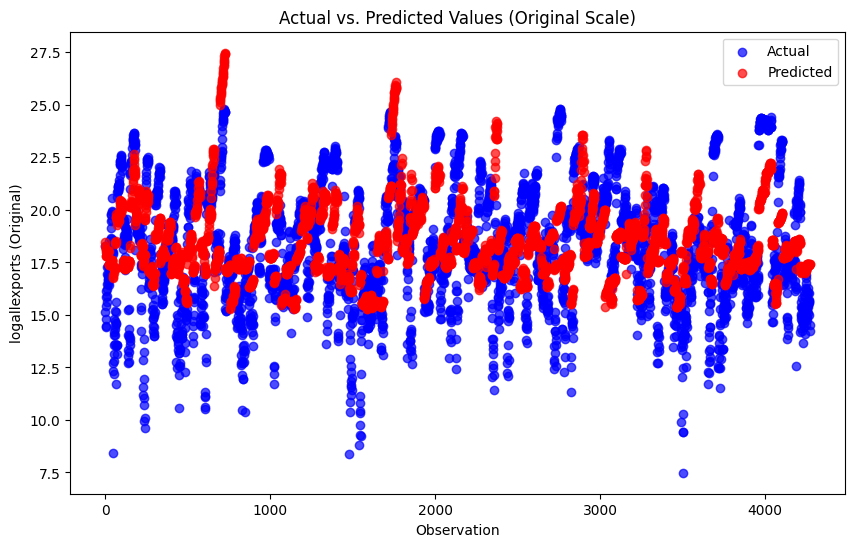

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y)), y, label='Actual', color='blue', alpha=0.7)
plt.scatter(range(len(y_pred_original)), y_pred_original, label='Predicted', color='red', alpha=0.7)
plt.xlabel("Observation")
plt.ylabel("logallexports (Original)")
plt.title("Actual vs. Predicted Values (Original Scale)")
plt.legend()
plt.show()